In [1]:
import numpy as np
import pickle
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('/Users/vsriniv/Documents/Research/Github/PatchSim')
import patchsim as sim
import hyperopt
import seaborn as sns
from hyperopt import hp, Trials
from tqdm import tqdm

In [2]:
gt = pd.read_csv('../data/ebola_drc_updates/Ebola_Updated_Aug2.csv',delimiter=',',dtype={'date':str})
gt['Date'] = gt.date.apply(lambda x: datetime.strptime(x,'%Y%m%d'))
gt = gt[gt.Date>=datetime.strptime('20180805','%Y%m%d')] ## Starting on August 5th, the first non-NaN value
gt['Ob_Day'] = gt.Date.apply(lambda x : (x - datetime.strptime('20180805','%Y%m%d')).days)
#gt['Ob_Week'] = gt.Ob_Day.apply(lambda x: x//7)

# Get top 10 healthzones
key_hzs = gt[gt.Date==gt.Date.max()][['health_zone','total_c']].sort_values('total_c',ascending=False).head(11)['health_zone'].values
key_hzs = sorted(list(set(key_hzs) - {'all'}))

T = len(gt[gt.health_zone=='all'])

In [3]:
##gt[gt.Ob_Day.isin([20, 100, 180, 220, 259])]['date'].unique()

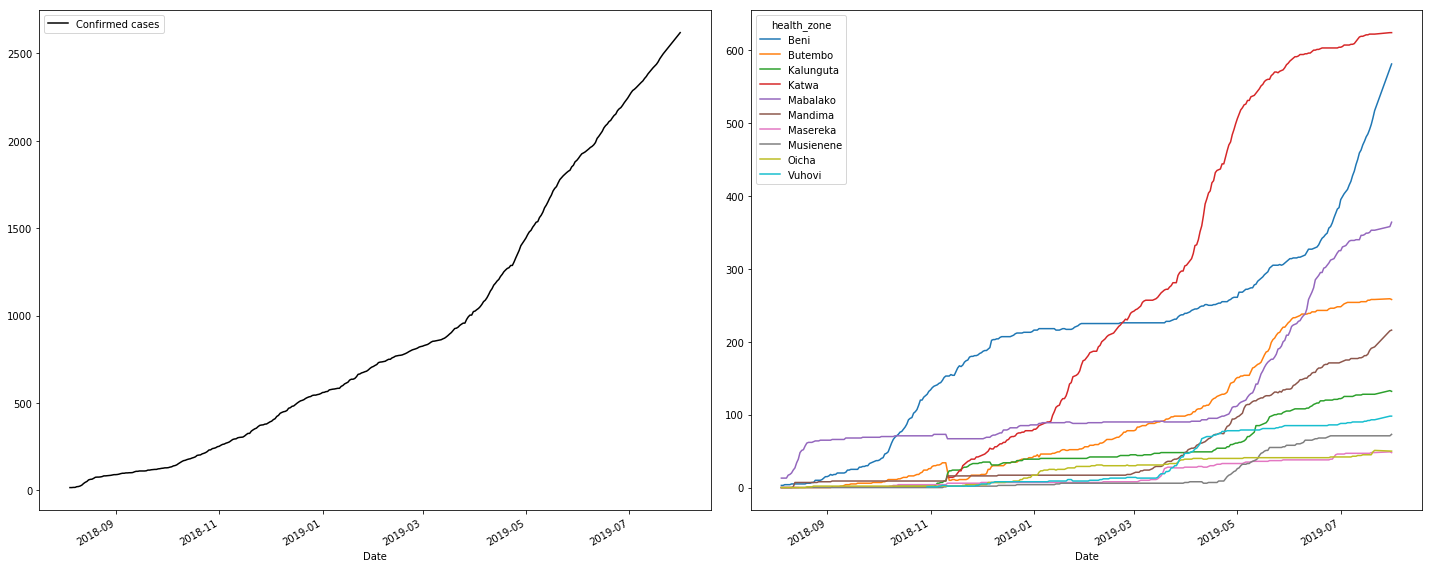

In [4]:
f, axarr = plt.subplots(1,2, figsize=(20,8))
gt[gt.health_zone=='all'].plot(x='Date',y='total_c',ax=axarr[0],color='k',label='Confirmed cases')
gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_c').plot(ax=axarr[1])

plt.tight_layout()
plt.savefig('../plots/case_counts.png',dpi=100)

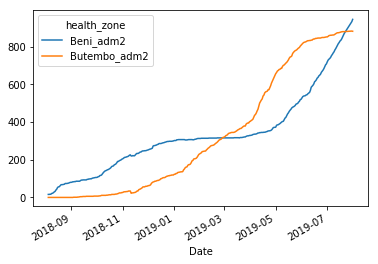

In [14]:
temp_df=gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_c').fillna(0)
temp_df['Beni_adm2'] = temp_df.Beni + temp_df.Mabalako
temp_df['Butembo_adm2'] = temp_df.Butembo + temp_df.Katwa
temp_df[['Beni_adm2','Butembo_adm2']].plot()

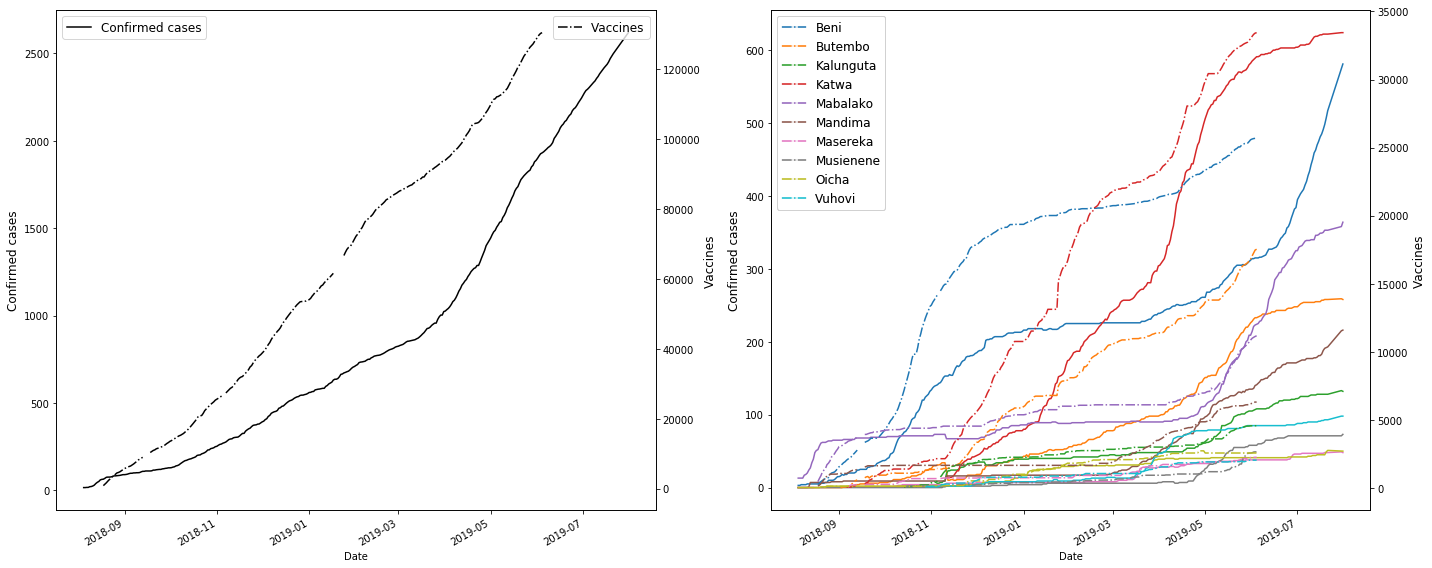

In [5]:
f, axarr = plt.subplots(1,2, figsize=(20,8))
gt[gt.health_zone=='all'].plot(x='Date',y='total_c',ax=axarr[0],color='k',label='Confirmed cases')
ax0 = axarr[0].twinx()
axarr[0].legend(loc=2,fontsize=12)
gt[gt.health_zone=='all'].plot(x='Date',y='total_vacc',ax=ax0, color='k', label='Vaccines', ls='-.')
ax0.legend(loc=1,fontsize=12)
axarr[0].set_ylabel('Confirmed cases',fontsize=12)
ax0.set_ylabel('Vaccines',fontsize=12)

gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_c').plot(ax=axarr[1])
ax1 = axarr[1].twinx()
gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_vacc').plot(ax=ax1, ls='-.')
axarr[1].set_ylabel('Confirmed cases',fontsize=12)
ax1.set_ylabel('Vaccines',fontsize=12)
ax1.legend(fontsize=12)
axarr[1].legend(fontsize=12)

plt.tight_layout()
plt.savefig('../plots/vax_case_curves.png',dpi=100)

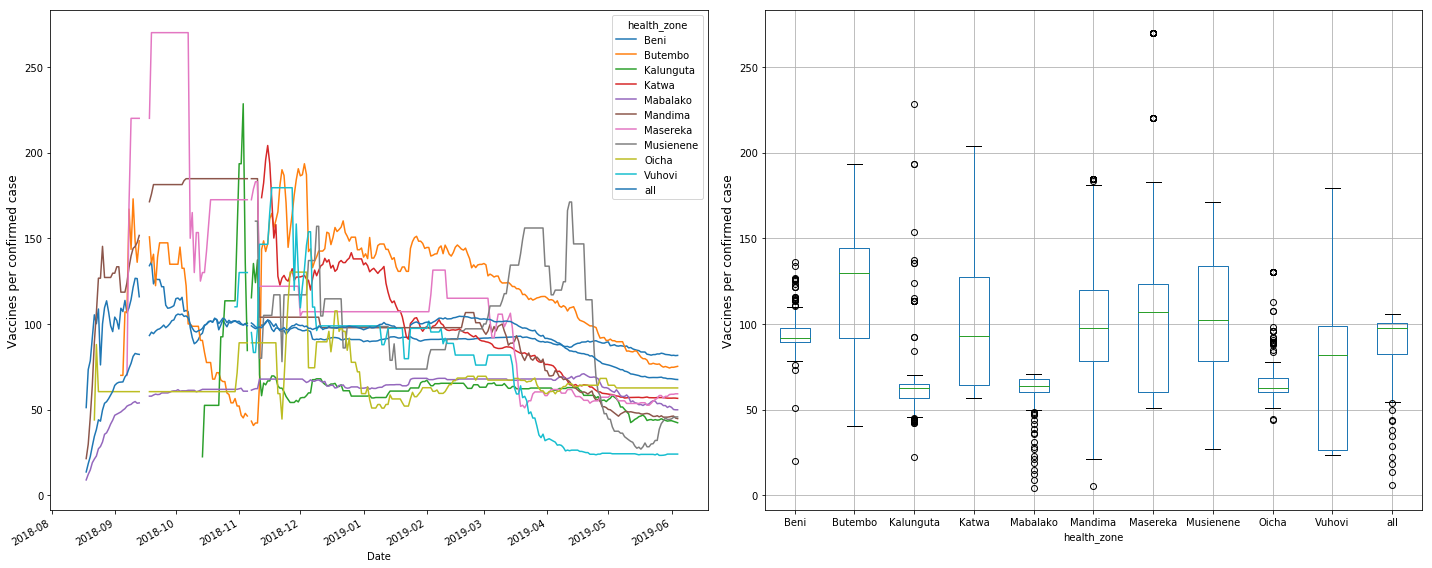

In [6]:
with np.errstate(divide='ignore'):
    gt['vacc_per_total_c'] = np.divide(gt.total_vacc.values,gt.total_c.values)
f,axarr = plt.subplots(1,2,figsize=(20,8))
gt[gt.health_zone.isin(key_hzs+['all'])].pivot(index='Date',columns='health_zone',values='vacc_per_total_c').plot(ax=axarr[0])
gt[gt.health_zone.isin(key_hzs+['all'])].boxplot(column='vacc_per_total_c',by='health_zone',ax=axarr[1])
axarr[0].set_ylabel('Vaccines per confirmed case',fontsize=12)
axarr[1].set_ylabel('Vaccines per confirmed case',fontsize=12)
axarr[1].set_title('')
plt.tight_layout()
plt.suptitle('')
plt.savefig('../plots/vax_case_ratio.png',dpi=100)

In [7]:
gt_pvt = gt[gt.health_zone.isin(key_hzs)].pivot(index='Date',columns='health_zone',values='total_c').fillna(0)

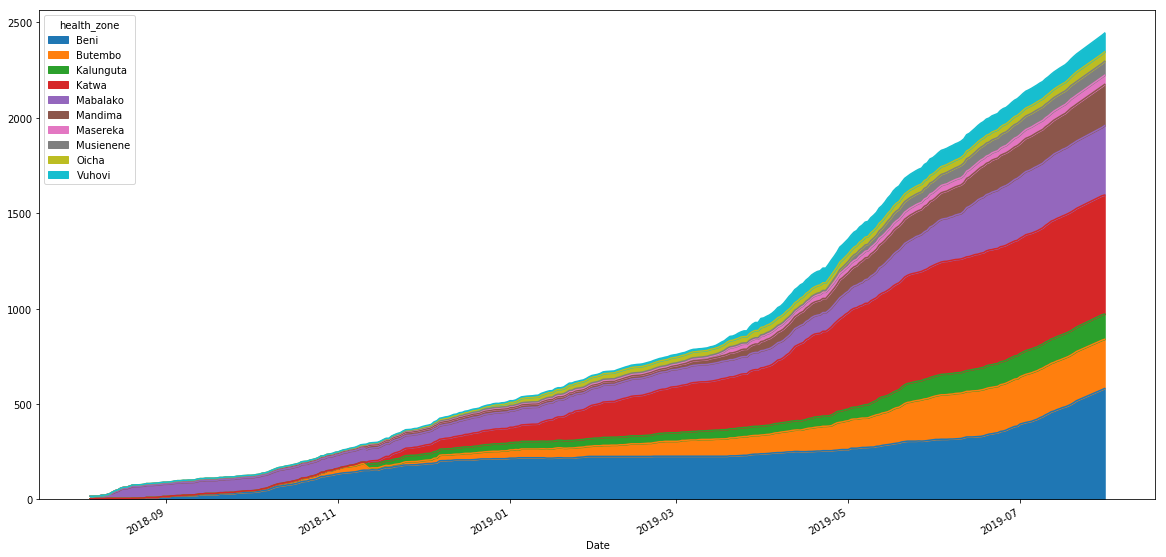

In [8]:
gt_pvt.plot(kind='area',stacked=True,figsize=(20,10))